# Machine learning model to read reviews

Question: how can we analyze a large number or revires with NPL?

Goal: enable companies to quickly extract the key topics covered from the customer feedback without having to read through them one by one

### Upload the data

In [1]:
# Import dependencies
from sqlalchemy import create_engine
import pandas as pd
import spacy

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns


#Libraries for lemmatization
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist

#Libraries for word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Postgres username, password, and database name

POSTGRES_ADDRESS = 'mypostgresdb.cwuhtytzosg8.us-east-2.rds.amazonaws.com' ## INSERT YOUR DB ADDRESS IF IT'S NOT ON PANOPLY
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'root' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES USERNAME
POSTGRES_PASSWORD = 'XXXX ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD
POSTGRES_DBNAME = 'my_data_class_db' ## CHANGE THIS TO YOUR DATABASE NAME
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username=POSTGRES_USERNAME,
password=POSTGRES_PASSWORD,
ipaddress=POSTGRES_ADDRESS,
port=POSTGRES_PORT,
dbname=POSTGRES_DBNAME))
# Create the connection
cnx = create_engine(postgres_str)

In [3]:
# Load database for sentiment/topic analysis
df = pd.read_sql_query('''SELECT * FROM airmattress_cleaned''', con=cnx)
df.head()

,customer_id,review_id,star_rating,review_headline,review_body
0,51982153,R1DZ76NBD2TX55,5,my wife and i had to pick one of these up over...,my wife and i had to pick one of these up over...
1,44662747,R3G4HN08IK8Q5W,5,this is big and comfortable it inflatesdeflat...,this is big and comfortable it inflatesdeflat...
2,17097525,R1S3TBZK71L487,1,horrible it was so comfortable for the first f...,horrible it was so comfortable for the first f...
3,29924839,R9P8YG335IDYV,5,we bought this so our friends kids would have ...,we bought this so our friends kids would have ...
4,46198682,R5VTP1LCQIATH,4,this bed exceeded my expectations in sturdines...,this bed exceeded my expectations in sturdines...


### Analyze reviews data

In [4]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count", color = 'black')
  ax.set(ylabel = 'Count')
  plt.show()

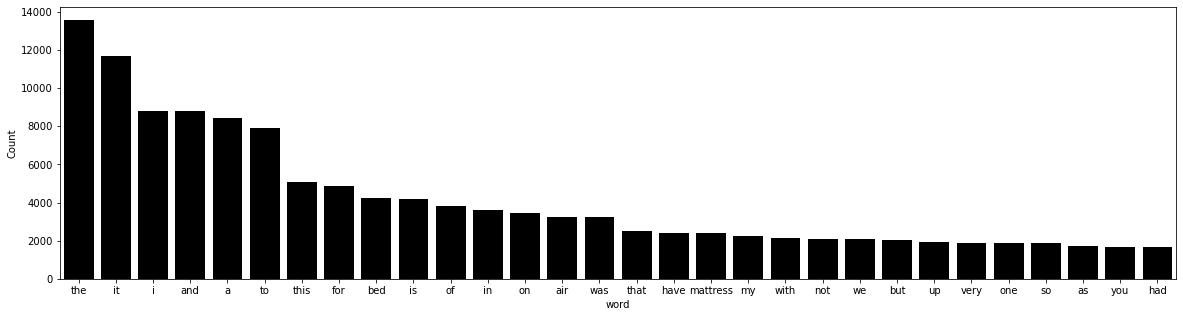

In [5]:
freq_words(df['review_body'])

In [6]:
# Remove unwanted characters, numbers and symbols
df['review_body'] = df['review_body'].str.replace("[^a-zA-Z#]", " ")
df

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,customer_id,review_id,star_rating,review_headline,review_body
0,51982153,R1DZ76NBD2TX55,5,my wife and i had to pick one of these up over...,my wife and i had to pick one of these up over...
1,44662747,R3G4HN08IK8Q5W,5,this is big and comfortable it inflatesdeflat...,this is big and comfortable it inflatesdeflat...
2,17097525,R1S3TBZK71L487,1,horrible it was so comfortable for the first f...,horrible it was so comfortable for the first f...
3,29924839,R9P8YG335IDYV,5,we bought this so our friends kids would have ...,we bought this so our friends kids would have ...
4,46198682,R5VTP1LCQIATH,4,this bed exceeded my expectations in sturdines...,this bed exceeded my expectations in sturdines...
...,...,...,...,...,...
4748,10221632,R2K0TL4VNH71AB,5,good buy very little leak the bed itself is ve...,good buy very little leak the bed itself is ve...
4749,52922779,R3FMSB7NVM64SP,5,this is a great thing to have the built in pum...,this is a great thing to have the built in pum...
4750,45643821,R3JPX7JXE4JF61,5,this air mattress is incredible we bought it ...,this air mattress is incredible we bought it ...
4751,14464916,R2XZEVT9OE0BXI,4,i have not had this item for very long and hav...,i have not had this item for very long and hav...


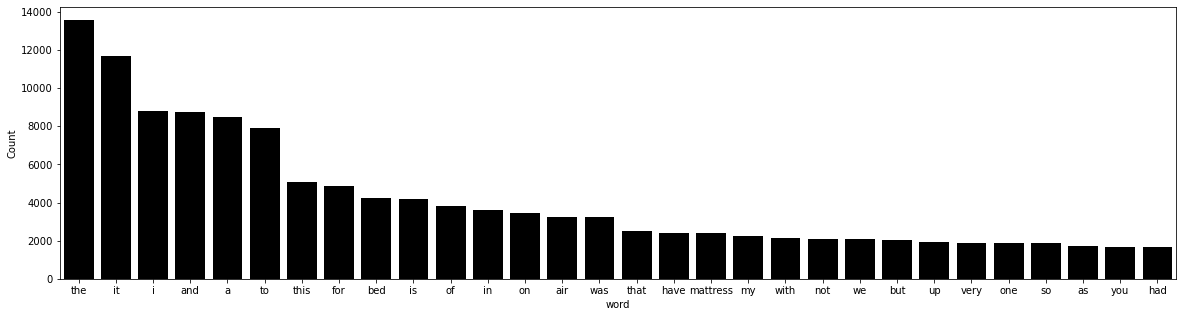

In [7]:
freq_words(df['review_body'])

In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# Remove short words (length < 3)
df['review_body'] = df['review_body'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# Exclude stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['review_body']]

In [9]:
# To remove noise from reviews, use lemmatization from spaCy library
!python -m spacy download en_core_web_sm 

  Using cached smart_open-3.0.0-py3-none-any.whl
  Attempting uninstall: smart-open
    Found existing installation: smart-open 2.0.0
    Uninstalling smart-open-2.0.0:
      Successfully uninstalled smart-open-2.0.0
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-05-01 14:40:29.674035: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-05-01 14:40:29.674076: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.0.1 requires Cython==0.29.21, but you have cython 0.29.23 which is incompatible.


In [10]:
# Use nlp to remove words that are not aggregating to analysis
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [11]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['big', 'comfortable', 'inflatesdeflates', 'unfoldfold', 'hope', 'lasts', 'long', 'time']


In [12]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['big', 'comfortable', 'inflatesdeflate', 'unfoldfold', 'hope', 'long', 'time']


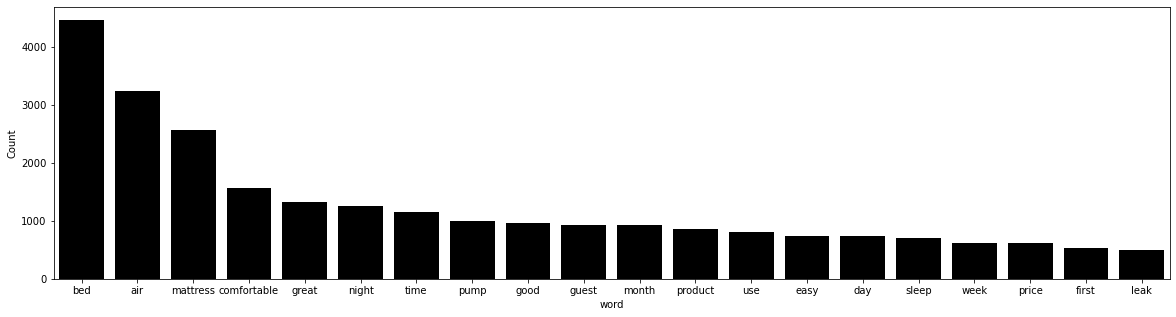

In [13]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 20)

### Create Latent Dirichlet Allocation (LDA) model

One application of LDA in machine learning - specifically, topic discovery, a subproblem in natural language processing - is to discover topics in a collection of documents, and then automatically classify any individual document within the collection in terms of how "relevant" it is to each of the discovered topics. A topic is considered to be a set of terms (i.e., individual words or phrases) that, taken together, suggest a shared theme. Souce: Wikipedia

Topic Modelling is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. It is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts. Source: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [14]:
import gensim
from gensim import corpora

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [15]:
# Create the term dictionary of our corpus, unique terms are assigned an index
dictionary = corpora.Dictionary(reviews_2)

In [16]:
# Transform list of reviews into a document term matrix
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [17]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model. In this case we specifified # of topics = 5
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5, random_state=100,
                chunksize=1000, passes=50)

In [18]:
# Print topics
lda_model.print_topics()

[(0,
  '0.015*"queen" + 0.013*"intex" + 0.009*"downy" + 0.009*"strong" + 0.008*"builtin" + 0.008*"smell" + 0.008*"new" + 0.007*"member" + 0.007*"kit" + 0.007*"work"'),
 (1,
  '0.038*"air" + 0.037*"time" + 0.032*"night" + 0.032*"bed" + 0.023*"first" + 0.019*"leak" + 0.018*"amazon" + 0.018*"mattress" + 0.017*"product" + 0.016*"day"'),
 (2,
  '0.063*"bed" + 0.044*"mattress" + 0.035*"air" + 0.021*"pump" + 0.020*"size" + 0.020*"sheet" + 0.019*"queen" + 0.014*"little" + 0.014*"comfortable" + 0.012*"night"'),
 (3,
  '0.056*"bed" + 0.051*"air" + 0.044*"comfortable" + 0.042*"great" + 0.034*"mattress" + 0.028*"easy" + 0.026*"guest" + 0.023*"good" + 0.021*"price" + 0.020*"pump"'),
 (4,
  '0.076*"bed" + 0.040*"month" + 0.032*"air" + 0.031*"mattress" + 0.017*"seam" + 0.014*"intex" + 0.014*"side" + 0.013*"product" + 0.013*"day" + 0.013*"middle"')]

### Topics visualization

In [19]:
# Import dependencies
import pyLDAvis
import pyLDAvis.gensim_models
%matplotlib inline

In [20]:
# Visualize topics
pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)

vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)

vis

C:\Users\li_mi\anaconda3\envs\PythonData\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.135358 -0.136180       1        1  28.926850
2     -0.067417 -0.148121       2        1  22.355103
1     -0.069583  0.154682       3        1  22.277216
4     -0.090869  0.142561       4        1  21.879178
0      0.363227 -0.012943       5        1   4.561652, topic_info=            Term         Freq        Total Category  logprob  loglift
87         month   876.000000   876.000000  Default  30.0000  30.0000
78         great  1177.000000  1177.000000  Default  29.0000  29.0000
217         easy   698.000000   698.000000  Default  28.0000  28.0000
254        queen   401.000000   401.000000  Default  27.0000  27.0000
54   comfortable  1439.000000  1439.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
741      matress    15.904425    59.547336   Topic5  -5.4370   1.7673
13        family    18.476194   188.404848   Topic5  -5.2871   0.7654
243        house    18.427265   207.900340   Topic5  -5.2898   0.6643
229     electric    17.498171   146.800609   Topic5  -5.3415   0.9605
53           big    16.244268   281.093064   Topic5  -5.4159   0.2365

[351 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
723       3  0.963446        aero
625       1  0.977259  affordable
0         1  0.387013         air
0         2  0.207562         air
0         3  0.223578         air
...     ...       ...         ...
94        1  0.192155        year
94        2  0.105451        year
94        3  0.335099        year
94        4  0.365563        year
533       3  0.968000       young

[504 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 5, 1])

References:
https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/

Next steps: should we remove words like air, mattress, bed, product, etc and redo the analysis